In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from pandas import DataFrame
import pandas as pd
from pennylane.templates.embeddings import AmplitudeEmbedding
from scipy.special import rel_entr
import math
import torch

In [2]:
print(qml.__version__)
print(torch.__version__)

0.15.1
1.4.0


Computing Expressibility-needed values

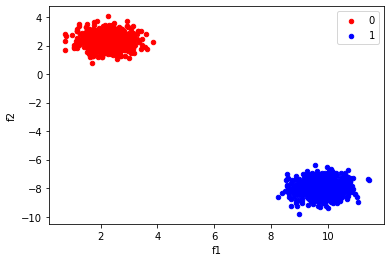

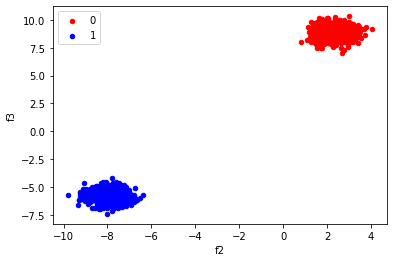

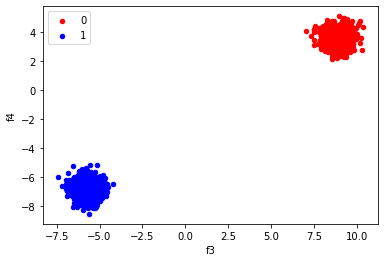

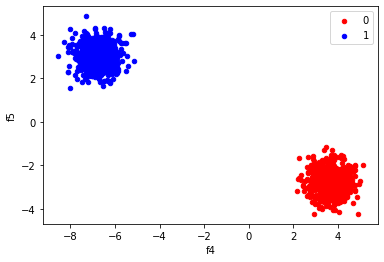

In [11]:
# Generate classification dataset and save it


# The smaller the cluster_std, the more appart and easier to distinguish they are
features, labels = make_blobs(n_samples=1500, centers=2, cluster_std=0.5, n_features=16)

features_dict = {}
for i in range(len(features[0])):
    col_name = "f" + str(i+1)
    features_dict [col_name] = features[:,i]
    
features_dict["label"] = labels
df = DataFrame(features_dict, labels)
df.to_csv('easy_dataset.csv')


# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='f1', y='f2', label=key, color=colors[key])
plt.show()

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='f2', y='f3', label=key, color=colors[key])
plt.show()

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='f3', y='f4', label=key, color=colors[key])
plt.show()

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='f4', y='f5', label=key, color=colors[key])
plt.show()

In [12]:
##### Code adapted from https://github.com/bagmk/Quantum_Machine_Learning_Express
fidelity = []
sampled_states = 2000
nshots = 1024
n_histograms = 76
N = 16
np.random.seed(0)

# Histogram bins
bins_list = [];
for i in range(n_histograms):
    bins_list.append((i) / (n_histograms - 1))
    
# Centers of the bins
bins_centers = []    
for i in range(n_histograms - 1):
    bins_centers.append(bins_list[1] + bins_list[i])

# Estimated distribution of Haar fidelities
# it is the integral of the Haar formula fidelity
# between the left and right values
def P_Haar(left_bin, right_bin, N):
    return (1 - left_bin)**(N - 1) - (1 - right_bin)**(N - 1)

# Haar histogram values
P_Haar_hist = []
for i in range(n_histograms - 1):
    P_Haar_hist.append(P_Haar(bins_list[i], bins_list[i+1], N))

In [13]:
dev = qml.device("default.qubit", wires=4)#, shots=1024)

In [14]:
num_qubits = 4
circuit_index = 4
num_layers = 3
weights_init = 2 * np.pi * np.random.rand(num_layers, num_qubits, 3, requires_grad=True)

print(weights_init.shape)

bias_init = np.array(0.0, requires_grad=True)
# print(weights_init, bias_init)

(3, 4, 3)


In [15]:
def layer_circuit_one(W):

    qml.RX(W[0,0], wires=0)
    qml.RX(W[1,0], wires=1)
    qml.RX(W[2,0], wires=2)
    qml.RX(W[3,0], wires=3)

    qml.RZ(W[0,1], wires=0)
    qml.RZ(W[1,1], wires=1)
    qml.RZ(W[2,1], wires=2)
    qml.RZ(W[3,1], wires=3)
    
def layer_circuit_two(W):
    
    layer_circuit_one(W)

    qml.CNOT(wires=[3, 2])
    qml.CNOT(wires=[2, 1])
    qml.CNOT(wires=[1, 0])
    
def layer_circuit_three(W):

    layer_circuit_one(W)

    qml.CRZ(W[0,2], wires=[3, 2])
    qml.CRZ(W[1,2], wires=[2, 1])
    qml.CRZ(W[2,2], wires=[1, 0])
    
def layer_circuit_four(W):

    #print(W.shape)
    
    layer_circuit_one(W)

    qml.CRX(W[0,2], wires=[3, 2])
    qml.CRX(W[1,2], wires=[2, 1])
    qml.CRX(W[2,2], wires=[1, 0])
    
layer_functions = [layer_circuit_one, layer_circuit_two, layer_circuit_three, layer_circuit_four]

In [16]:
def statepreparation(x):
    AmplitudeEmbedding(features=x, wires=[0, 1, 2, 3],normalize="True")

In [17]:
@qml.qnode(dev)
def circuit(circuit_index, weights, input_data, mode, result):
    
    #print(circuit_index)

    statepreparation(input_data)

    for W in weights:
        layer_functions[circuit_index-1](W)
    
    if mode == "entanglement":
        print(type(list(result.numpy())))#.numpy())))
        print(type(list(dev.state)))
        result = torch.cat((result, dev.state), 0)
        print(result)
        return qml.sample() #qml.expval(qml.PauliZ(0))
    
    elif mode == "qml":
        #print("hereqml")
        return qml.expval(qml.PauliZ(0))#, qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))] # for qml
    
    elif mode == "expressibility":
        return qml.sample()#qml.PauliZ(0), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3)))
    
    else:
        raise ValueError("The circuit result modes can be: entanglement, expressibility or qml." + 
                         mode + 
                         "is not a valid circuit result mode.") 
    

In [18]:
X = np.array(features, requires_grad=False)
Y = np.array(labels, requires_grad=False)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

#for i in range(5):
#    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))

num_data = len(Y)
num_train = int(0.75 * num_data)
num_val = int(0.90 * num_data)

#shuffling the data before dividing it into train, test and validation
index = np.random.permutation(range(num_data))

feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]

feats_val = features[index[num_train:num_val]]
Y_val = Y[index[num_train:num_val]]

feats_test = features[index[num_val:]]
Y_test = Y[index[num_val:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:num_val]]
X_test = X[index[num_val:]]

In [19]:
#def variational_classifier(circuit_index, weights, bias, input_data, mode):
#weights_init = 2 * np.pi * np.random.rand(num_layers, num_qubits, 3, requires_grad=True)
#drawer = qml.draw(circuit)
#print(drawer(circuit_index, weights_init, X[0], "qml"))

def variational_classifier(weights, bias, input_data, mode, state):
    return circuit(circuit_index, weights, input_data, mode, state) + bias

def qml_variational_classifier(weights, bias, input_data, state):
    return circuit(circuit_index, weights, input_data, "qml", state) + bias

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):

    acc = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            acc = acc + 1
    acc = acc / len(labels)

    return loss

#def cost(circuit_index, weights, bias, mode, X, Y):
def cost(weights, bias, X, Y):
    predictions = [qml_variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [20]:
##### More code adapted from https://github.com/bagmk/Quantum_Machine_Learning_Express
sampled_states = 2000
x = X_train[0]
for state in range(sampled_states):
    weights_init = np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
    #result = variational_classifier(circuit_index, weights_init, bias_init, x, mode="expressibility")
    result = variational_classifier(weights_init, bias_init, x, mode="expressibility")
    result_strings = ["".join(map(str, [int(res[0]), int(res[1]), int(res[2]), int(res[3])])) for res in result.numpy()]
    ratio = result_strings.count("0000") / nshots
    fidelity.append(ratio)

weights = np.ones_like(fidelity) / float(len(fidelity))
plt.hist(fidelity, bins=bins_list, weights=weights, range=[0, 1], label='Circuit')
plt.plot(bins_centers, P_Haar_hist, label='Haar')
plt.legend(loc='upper right')
plt.show()

# example of calculating the kl divergence (relative entropy) with scipy
P_1_hist = np.histogram(fidelity, bins=bins_list, weights=weights, range=[0, 1])[0]
kl_pq = rel_entr(P_1_hist, P_Haar_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

TypeError: variational_classifier() missing 1 required positional argument: 'state'

Let's do the Entanglement capability

In [21]:
def to_string(qubit):
    my_list = list(qubit.numpy())
    #print("list", my_list)
    return ''.join(str(elem) for elem in my_list)

def D_distance(vec_1, vec_2):
    #print(vec_1)
    #print(vec_2)
    assert len(vec_1) == len(vec_2)
    d = 0
    for i in range(len(vec_1)):
        for j in range(len(vec_2)):
            d = d + abs(vec_1[i]*vec_2[j] - vec_1[j]*vec_2[i])**2
    return d / 2

def get_coeff_idx(qubit):
    #print("[to become int] qubit is : ", qubit)
    #print(int(to_string(qubit), 2))
    return int(to_string(qubit), 2)

def i_func(i, j, vectorised_psi, n):
    final_coeffs = np.zeros(2**n, dtype=np.complex64)
    
    #print(i, j)
    
    for basis_probability_idx in range(len(vectorised_psi)):
        basis_probability = vectorised_psi[basis_probability_idx]
        #print(f"basis_probability: {basis_probability}")
        
        basis_state_str = str(bin(basis_probability_idx))[2:]
        
        while len(basis_state_str) != n:
            basis_state_str = "0" * (n-len(basis_state_str)) + basis_state_str
            
        #print(f"basis_state_str: {basis_state_str}")
        #
        basis_state = np.array([int(d) for d in basis_state_str])
        #print(f"basis_state: {basis_state}")

        array_qubit_removed = np.delete(basis_state, j)
        
        coeff_idx = get_coeff_idx(array_qubit_removed)
    
        if basis_state[j] == i:
            final_coeffs[coeff_idx] = final_coeffs[coeff_idx] + basis_probability
            
    #print(f"final_coeffs: {final_coeffs}")

    return final_coeffs


n = 2
N = 2**n
q_01 = 0
psi_test = np.array([1, 0, 0, 0])
for j in range(n):
    i0 = i_func(0, j, psi_test, n)
    i1 = i_func(1, j, psi_test, n)
    #print(i0, i1)
q_01 = q_01 + D_distance(i0, i1)
q_01 = q_01 * 4 / n
print(q_01)

n = 2 # number of qubits
N = 2**n
q_01 = 0
psi_test = np.array([1/math.sqrt(2), 0, 0, 1/math.sqrt(2)])
#print(psi_test)
# I work on vectorised qubits
N = 2**n #dim of Hilbert space
for j in range(n): 
    #print("j is ", j)
    i0 = i_func(0, j, psi_test, n)
    i1 = i_func(1, j, psi_test, n)
    #print("final i0, final i1")
    #print(i0, i1)
    d = D_distance(i0, i1)
    q_01 = q_01 + d
    #print(d)
    #print("####")
q_01 = q_01 * 4 / n
print(q_01)


print("###########GHZ#########")
n = 3 # number of qubits
N = 2**n
q_01 = 0
psi_test = np.array([1/math.sqrt(2),0,0,0,0,0,0,-1/math.sqrt(2)])
print(len(psi_test))
# I work on vectorised qubits
N = 2**n #dim of Hilbert space
for j in range(n): 
    #print("j is ", j)
    i0 = i_func(0, j, psi_test, n)
    i1 = i_func(1, j, psi_test, n)
    #print("final i0, final i1")
    #print(i0, i1)
    d = D_distance(i0, i1)
    q_01 = q_01 + d
    #print(d)
    #print("####")
q_01 = q_01 * 4 / n
print(q_01)

0.0
0.9999999315429177
###########GHZ#########
8
0.9999999315429177


In [22]:
sampled_weights = 5
sampled_states = 5
state_sampling_step = 5
print_every = 1
Q_arr = np.zeros(sampled_weights)
# Entanglement of circuit varies with < 1%, depending on the embedding parameters given
# by the input data, so for each input state we will do 50 sampled states and average their entanglement

def Q_entanglement():
    
    Q = 0
    #weights_init = 2 * np.pi * np.random.rand(num_layers, num_qubits, 3, requires_grad=True)
    
    for weight_idx in range(sampled_weights):
        weights_init = 2 * np.pi * np.random.rand(num_layers, num_qubits, 3, requires_grad=True)
        bias_init = np.array(0.0, requires_grad=True)
        
        #weight_Q = 0
        
        for state_idx in range(sampled_states):
        
            x = X_train[state_sampling_step * state_idx % len(X_train)]
            
            psi_init = []
            
            #psi = np.sqrt(variational_classifier(circuit_index, weights_init, bias_init, x, mode="entanglement"))
            x = variational_classifier(weights_init, bias_init, x, "entanglement", psi_init)
            
            print(psi_init)
            #print(psi.shape)
            
            n = 4
            N = 2**n
            q = 0
            for j in range(n):
                #print(j)
                i0 = i_func(0, j, psi, n)
                i1 = i_func(1, j, psi, n)
                #print(i0, i1)
                q = q + D_distance(i0, i1)
            q = q * 4 / n
            print(q)
            Q = Q + q
        
            if state_idx % print_every == 0:
                print(f"{state_idx+1}st sample\tEntanglement so far: ", Q)
            
        #Q = Q + weight_Q / sampled_states
        #Q_arr[weight_idx] = Q
        
    #np.save("entanglements", Q_arr)
    return Q / (sampled_weights * sampled_states)

Q_entanglement()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
# Taken from Pennylane tutorial
opt = NesterovMomentumOptimizer(0.1)
batch_size = 5
print_every = 5

weights = weights_init
bias = bias_init

history_train = []
history_validation = []
epochs = 30

# TODO : if val_acc decreases for 5 epochs, stop training
best_weights = None # the one which has the highest validation accuracy
max_acc_val = 0

for it in range(epochs):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_train_batch = X_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(qml_variational_classifier(weights, bias, f)) for f in X_train]
    predictions_val = [np.sign(qml_variational_classifier(weights, bias, f)) for f in X_val]
    
    if it == epochs - 1:
    
        df1 = DataFrame(dict(x=X_val[:,0], y=X_val[:,1], label=Y_val))
        colors1 = {-1:'red', 1:'blue'}
        fig, ax = plt.subplots()
        grouped = df1.groupby('label')
        for key, group in grouped:
            group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors1[key], s=50, alpha=0.5)
        #plt.plot()


        df2 = DataFrame(dict(x=X_val[:,0].numpy(), y=X_val[:,1].numpy(), label=predictions_val))
        colors2 = {-1:'orange', 1:'green'}
        fig, ax = plt.subplots()
        grouped2 = df2.groupby('label')
        for key, group in grouped2:
            key = key.numpy()
            group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors2[key], s=50, alpha=0.5)
        plt.plot()

        #result = pd.merge(df1, df2,  how='left', left_on=['x','y'], right_on = ['x','y'])
    
        #print(result.head)

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    
    if acc_val > max_acc_val:
        max_acc_val = acc_val
        best_weights = weights
    
    history_train.append(acc_train)
    history_validation.append(acc_val)
    
    if it > 5 and history_validation[-1] > history_validation[-2] and history_validation[-2] > history_validation[-3]:
        break
    
    #if it % 5 == 0:

    print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
            "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
        )

In [ ]:
plt.plot(history_train)
plt.plot(history_validation)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Compute accuracy on the test data
predictions_test = [np.sign(qml_variational_classifier(best_weights, bias, f)) for f in X_test]
acc_test = accuracy(Y_test, predictions_test)
print(acc_test)